In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jena-climate/jena_climate_2009_2016.csv


> **#Datasets: IMDB Movie Reviews + Jena Climate******

In [74]:

#use AI to know what should import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from wordcloud import WordCloud
from statsmodels.tsa.stattools import adfuller
from collections import Counter


Part [1] EDA

1)Text EDA

In [75]:
#IMDB Movie Reviews
imdb_data, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_ds, test_ds = imdb_data['train'], imdb_data['test']


train_texts, train_labels = [], []
for text, label in tfds.as_numpy(train_ds):
    train_texts.append(text.decode('utf-8'))
    train_labels.append(int(label))

test_texts, test_labels = [], []
for text, label in tfds.as_numpy(test_ds):
    test_texts.append(text.decode('utf-8'))
    test_labels.append(int(label))
#use AI to know tensorflow datasets

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


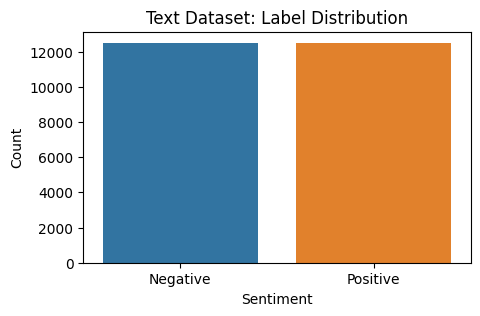

In [76]:
#text-Label distribution
plt.figure(figsize=(5,3))
sns.countplot(x=train_labels)
plt.title("Text Dataset: Label Distribution")
plt.xticks([0,1], ['Negative', 'Positive'])
plt.xlabel("Sentiment"); plt.ylabel("Count")
plt.show()

In [77]:
lengths = [len(t.split()) for t in train_texts]
print("Average length:", np.mean(lengths))

Average length: 233.7872


In [78]:
freq = Counter(" ".join(train_texts).split())
print("Most common words:", freq.most_common(10))

Most common words: [('the', 287032), ('a', 155096), ('and', 152664), ('of', 142972), ('to', 132568), ('is', 103229), ('in', 85580), ('I', 65973), ('that', 64560), ('this', 57199)]


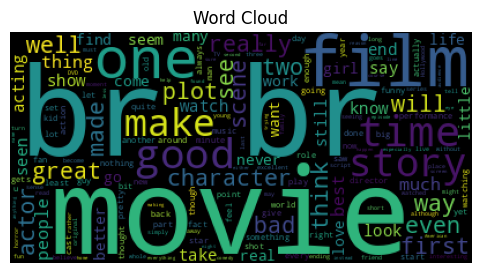

Sample positive: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf …
Sample negative: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  …


In [79]:
#Text WordCloud and Sample Positive/Negative Reviews
from wordcloud import WordCloud
wc = WordCloud(width=400, height=200).generate(" ".join(train_texts[:500]))
plt.figure(figsize=(6,3))
plt.imshow(wc)
plt.axis('off')
plt.title("Word Cloud")
plt.show()
pos_idx = np.where(np.array(train_labels) == 1)[0][0]
neg_idx = np.where(np.array(train_labels) == 0)[0][0]

print("Sample positive:", train_texts[pos_idx][:200], "…")
print("Sample negative:", train_texts[neg_idx][:200], "…")

2)TS EDA

In [80]:
#input dataset
df_ts = pd.read_csv('/kaggle/input/jena-climate/jena_climate_2009_2016.csv')
df_ts['Date Time'] = pd.to_datetime(df_ts['Date Time'], dayfirst=True)

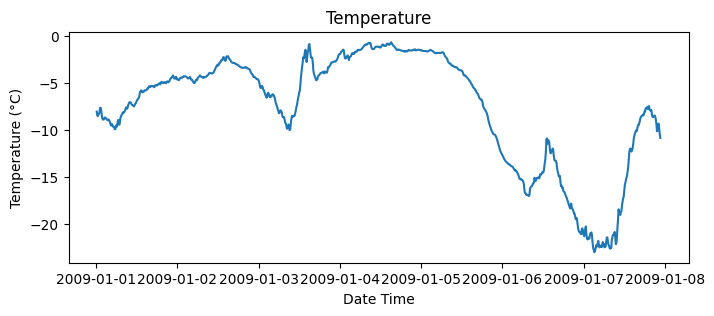

In [107]:
#plots
#temp
plt.figure(figsize=(8,3))
plt.plot(df_ts['Date Time'][:1000], df_ts['T (degC)'][:1000])
plt.title("Temperature")
plt.xlabel("Date Time"); plt.ylabel("Temperature (°C)")
plt.show()

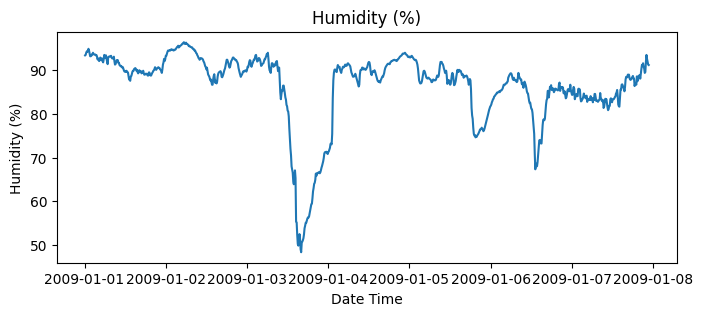

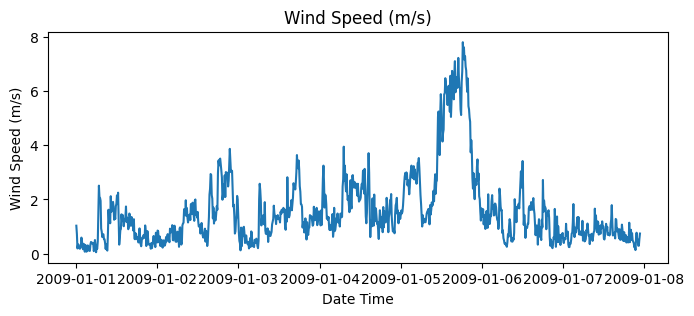

In [108]:
#humidity
plt.figure(figsize=(8,3))
plt.plot(df_ts['Date Time'][:1000], df_ts['rh (%)'][:1000])
plt.title("Humidity (%)")
plt.xlabel("Date Time"); plt.ylabel("Humidity (%)"); plt.show()

#wind speed
plt.figure(figsize=(8,3))
plt.plot(df_ts['Date Time'][:1000], df_ts['wv (m/s)'][:1000])
plt.title("Wind Speed (m/s)")
plt.xlabel("Date Time"); plt.ylabel("Wind Speed (m/s)"); plt.show()

In [82]:
#Missing value handling
print("Missing values per column:")
print(df_ts.isnull().sum())
df_ts.fillna(method='ffill', inplace=True)

Missing values per column:
Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


/tmp/ipykernel_35/3831895384.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_ts.fillna(method='ffill', inplace=True)


In [83]:
#Text - Convert Test Set Using Same Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)
test_texts, test_labels = [], []
for text, label in tfds.as_numpy(test_data):
    test_texts.append(text.decode('utf-8'))
    test_labels.append(int(label))

In [84]:
#ADF
sample_temp = df_ts['T (degC)'].dropna().iloc[:5000]
result = adfuller(sample_temp)
print(f"ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
for k, v in result[4].items():
    print(f"Critical Value ({k}): {v:.4f}")

ADF Statistic: -3.9282, p-value: 0.0018
Critical Value (1%): -3.4317
Critical Value (5%): -2.8621
Critical Value (10%): -2.5671


Part [2]: Data Preprocessing

1)Text preprocess

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [86]:
# Tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)
train_seqs = tokenizer.texts_to_sequences(train_texts)
test_seqs  = tokenizer.texts_to_sequences(test_texts)

In [87]:
# Padding
train_padded = pad_sequences(train_seqs, maxlen=200, truncating='post')
test_padded  = pad_sequences(test_seqs,  maxlen=200, truncating='post')


In [88]:
# split train/validation dataset
train_labels = np.array(train_labels)
X_train, X_val, y_train, y_val = train_test_split(
    train_padded, train_labels, test_size=0.2, random_state=42
)

In [89]:
#Test dataset

X_test, y_test = test_padded, np.array(test_labels)

print("Text shapes ->",
      "X_train:", X_train.shape,
      "X_val:",   X_val.shape,
      "X_test:",  X_test.shape)

Text shapes -> X_train: (20000, 200) X_val: (5000, 200) X_test: (25000, 200)


2)TS preprocess

In [90]:
#select key features
features = ['T (degC)', 'p (mbar)', 'rh (%)', 'wv (m/s)']
vals = df_ts[features].values
scaler = MinMaxScaler()
vals_scaled = scaler.fit_transform(vals)

#use AI to know how to sationarity check

In [91]:
#TS-Sliding Window Sequence Generation
def create_sequences(data, window=144):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])
    return np.array(X), np.array(y)

window = 144
X_seq, y_seq = create_sequences(vals_scaled, window)

In [92]:
# split Train / Test
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_test_seq = y_seq[:split_idx], y_seq[split_idx:]

print("Time-series shapes ->", 
      "X_train_seq:", X_train_seq.shape, 
      "X_test_seq:",  X_test_seq.shape)

Time-series shapes -> X_train_seq: (336325, 144, 4) X_test_seq: (84082, 144, 4)


Part [3]: Model Building

In [93]:
#use AI to know what should import
import tensorflow as tf
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error


In [94]:
#Use AI to guide me how to stop early and save the best model
es      = callbacks.EarlyStopping(patience=3, restore_best_weights=True)
cp_text = callbacks.ModelCheckpoint('best_text_model.h5', save_best_only=True)
cp_seq  = callbacks.ModelCheckpoint('best_seq_model.h5', save_best_only=True)

1)Text Model

In [95]:
#Reuse settings from previous code to parameters
vocab_size = 10000
embed_dim  = 16
maxlen     = 200

In [96]:
#SimpleRNN
#Use AI to correct whether RNN is used correctly
model_text_rnn = tf.keras.Sequential([
    layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
    layers.SimpleRNN(32),
    layers.Dropout(0.5), #Use ai to get Dropout format
    layers.Dense(1, activation='sigmoid')
])
model_text_rnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [97]:
#LSTM
#Using AI to get way to use LSTM, I understand it as "a more powerful RNN")
model_text_lstm = tf.keras.Sequential([
    layers.Embedding(vocab_size, embed_dim, input_length=maxlen),
    layers.LSTM(32),  
    layers.Dense(1, activation='sigmoid')
])
model_text_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [98]:
#example of training(RNN)
history_text_rnn = model_text_rnn.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[es, cp_text])

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.5149 - loss: 0.6953 - val_accuracy: 0.6008 - val_loss: 0.6594
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7214 - loss: 0.5786 - val_accuracy: 0.6652 - val_loss: 0.6116
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.8095 - loss: 0.4475 - val_accuracy: 0.8008 - val_loss: 0.4421
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8919 - loss: 0.2874 - val_accuracy: 0.8102 - val_loss: 0.4431
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9289 - loss: 0.2032 - val_accuracy: 0.7682 - val_loss: 0.5346


In [99]:
#example of training(LSTM)
history_text = model_text_lstm.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[es, cp_text]
)




Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.5845 - loss: 0.6562 - val_accuracy: 0.8156 - val_loss: 0.4200
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.8654 - loss: 0.3311 - val_accuracy: 0.8564 - val_loss: 0.3393
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.9192 - loss: 0.2266 - val_accuracy: 0.8578 - val_loss: 0.3454
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.9370 - loss: 0.1837 - val_accuracy: 0.8610 - val_loss: 0.3567
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.9536 - loss: 0.1430 - val_accuracy: 0.8298 - val_loss: 0.4253


2)TS Model

In [100]:
# Reuse data from previous code
window       = X_train_seq.shape[1]      # 144
n_features   = X_train_seq.shape[2]      # 特征数，例如 4

In [101]:
#SimpleRNN
model_seq_rnn = tf.keras.Sequential([
    layers.SimpleRNN(32, input_shape=(window, n_features)),
    layers.Dropout(0.3),
    layers.Dense(1)
])
model_seq_rnn.compile(
    loss='mse',
    optimizer='adam'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
#LSTM
model_seq_lstm = tf.keras.Sequential([
    layers.LSTM(32, input_shape=(window, n_features)),
    layers.Dense(1)
])
model_seq_lstm.compile(
    loss='mse',
    optimizer='adam'
)

In [103]:
# example of training (RNN)
history_seq_rnn = model_seq_rnn.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, cp_seq]
)
#example of training(LSTM)
history_seq = model_seq_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, cp_seq]
)

Epoch 1/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 108s 25ms/step - loss: 0.0195 - val_loss: 6.7369e-05
Epoch 2/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 105s 25ms/step - loss: 5.0039e-04 - val_loss: 5.1179e-05
Epoch 3/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 106s 25ms/step - loss: 4.2560e-04 - val_loss: 9.8592e-05
Epoch 4/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 107s 25ms/step - loss: 3.8019e-04 - val_loss: 4.3183e-05
Epoch 5/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 105s 25ms/step - loss: 3.8174e-04 - val_loss: 1.2975e-04
Epoch 1/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 243s 57ms/step - loss: 0.0043 - val_loss: 4.2563e-05
Epoch 2/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 240s 57ms/step - loss: 3.9752e-05 - val_loss: 3.4224e-05
Epoch 3/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 240s 57ms/step - loss: 2.6287e-05 - val_loss: 2.2492e-05
Epoch 4/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 243s 58ms/step - loss: 1.8682e-05 - val_loss: 4.0908e-05
Epoch 5/5
4205/4205 ━━━━━━━━━━━━━━━━━━━━ 243s 58ms/step - loss: 1.5094e-05 - val_loss: 1.3512e-05


Part [4]: Model Evaluation

1)Text Evaluation

782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step
Text Evaluation
              precision    recall  f1-score   support

    Negative       0.80      0.91      0.85     12500
    Positive       0.90      0.77      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



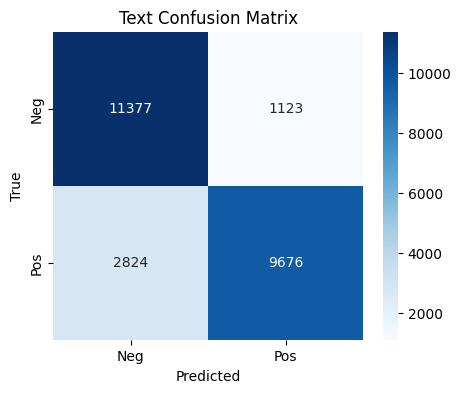

In [104]:
y_prob = model_text_lstm.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)

print("Text Evaluation")
print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Neg','Pos'],
            yticklabels=['Neg','Pos'],
            cmap='Blues')
plt.title('Text Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

2)TS Evaluation

2628/2628 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step
=== Time-Series Metrics ===
RMSE: 0.004
MAE:  0.003


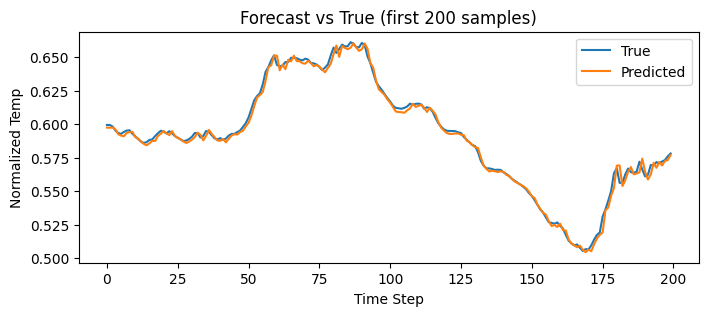

In [105]:
#Use AI to get the specific code for timing prediction evaluation
y_pred_seq = model_seq_lstm.predict(X_test_seq).flatten()

rmse = mean_squared_error(y_test_seq, y_pred_seq, squared=False)
mae  = mean_absolute_error(y_test_seq, y_pred_seq)
print(f"=== Time-Series Metrics ===\nRMSE: {rmse:.3f}\nMAE:  {mae:.3f}")
#Plot the predictions vs the actuals for the first 200 steps
plt.figure(figsize=(8,3))
plt.plot(y_test_seq[:200], label='True')
plt.plot(y_pred_seq[:200], label='Predicted')
plt.title('Forecast vs True (first 200 samples)')
plt.xlabel('Time Step'); plt.ylabel('Normalized Temp')
plt.legend()
plt.show()